<a href="https://colab.research.google.com/github/marcochisci/Anomaly_detection/blob/main/10min_1day_AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airquino table Data
Average data values (every 10 minutes) of the 30 days before the 30-th of September (included).


We want to find the 30-th of September's anomalies

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-09-01 03:30:00,318.500000,2.500000,427.000000,24.995000,16.800000,3.000000,869.500000,310.500000,214.000000,299.500000
2021-09-01 03:40:00,323.166667,2.833333,434.833333,28.025000,16.750000,4.833333,871.666667,248.333333,213.833333,306.500000
2021-09-01 03:50:00,321.142857,2.142857,431.285714,28.888571,16.728571,4.428571,866.428571,203.285714,213.714286,302.571429
2021-09-01 04:00:00,290.500000,1.333333,418.333333,29.063333,17.150000,2.666667,809.166667,137.000000,210.500000,291.000000
2021-09-01 04:10:00,263.285714,1.285714,419.142857,29.171429,17.085714,3.428571,800.857143,127.142857,208.428571,288.285714
...,...,...,...,...,...,...,...,...,...,...
2021-09-30 23:20:00,138.250000,5.000000,408.750000,31.795000,20.450000,7.000000,634.750000,33.250000,211.000000,270.750000
2021-09-30 23:30:00,136.142857,5.000000,408.857143,31.705714,20.357143,7.428571,633.000000,31.571429,211.000000,268.857143
2021-09-30 23:40:00,132.250000,5.000000,407.000000,31.725000,20.525000,6.750000,626.000000,31.750000,210.250000,269.000000


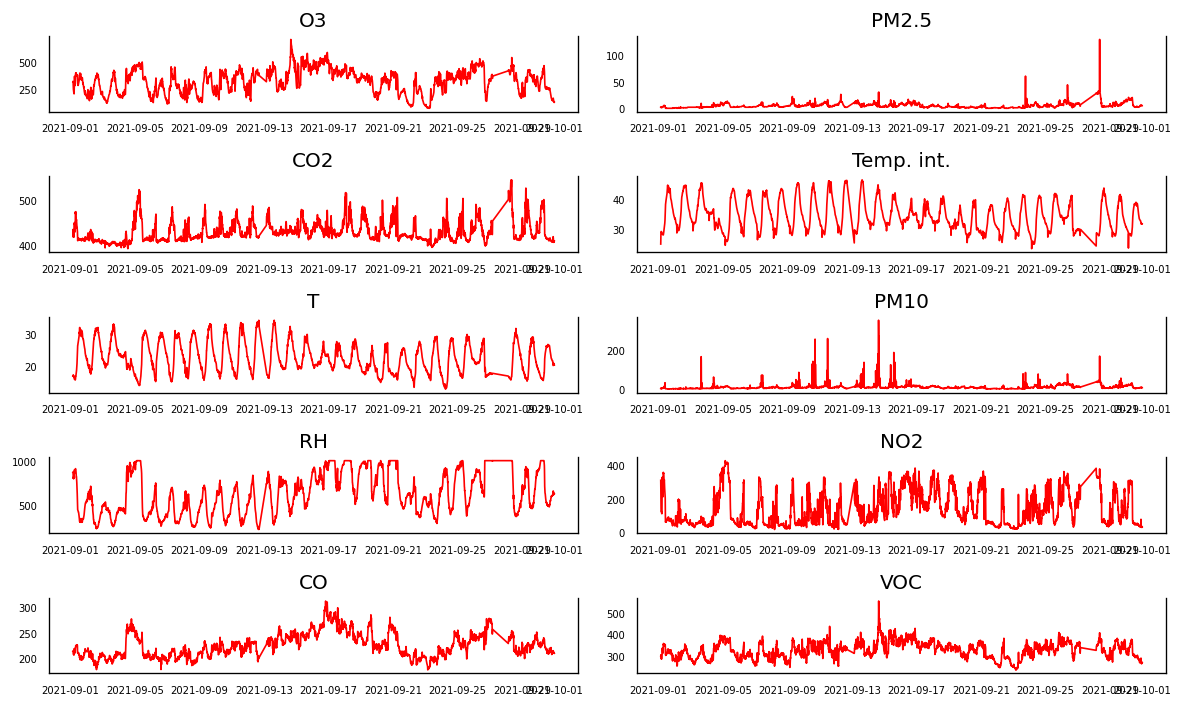

In [1]:
import pandas as pd
import psycopg2
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np
%matplotlib inline


conn = psycopg2.connect(host='playground.magentalab.it', port='45432', database='airqino', user='datareader', password='homntLZnlhQd9prtVA9SFezQek')

query=""" select time_bucket('10 minutes', c."Dates" ) as "bucket", avg(c."O3") as "O3" ,  avg(c."PM2.5") as "PM2.5", avg(c."CO2") as "CO2",
 avg(c."Temp. int.") as "Temp. int.",  avg(c."T") as "T",  avg(c."PM10") as "PM10", avg(c."RH") as "RH", avg(c."NO2") as 
 "NO2", avg(c."CO") as "CO", avg(c."VOC") as "VOC"
from (select * from crosstab(
  'select sd.data_acquired as timestamp, s.sensor_type ,  sd.float_value as value 
from station_data sd join sensor s on s.id = sd.sensor_id
where sd.data_acquired >= to_timestamp(''2021-09-01 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
 and sd.data_acquired <= to_timestamp(''2021-10-01 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
and sd.station_id = 23284701 order by sd.data_acquired asc, 1'
 , $$VALUES ('O3'::varchar), ('PM2.5'::varchar), ('CO2'::varchar), ('Temp. int.'::varchar), ('T'::varchar)
 , ('PM10'::varchar), ('RH'::varchar), ('NO2'::varchar), ('CO'::varchar), ('VOC'::varchar)$$
) AS value ("Dates" timestamp, "O3" float, "PM2.5" float, "CO2" float, "Temp. int." float, "T" float, "PM10" float,
"RH" float, "NO2" float, "CO" float, "VOC" float))  c 
group by bucket
order by bucket asc;
 """
df = pd.read_sql(query, conn)
df= df.rename(columns={'bucket': 'Dates'})
df=df.set_index('Dates')
#fix temp int
df['Temp. int.'] = df['Temp. int.'].div(100)
df['T'] = df['T'].div(10)

display(df)

# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data_in = df[df.columns[i]]
    ax.plot(data_in, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Testing stationarity 

In [2]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results = {
    col: test_stationarity(df, col)
    for col in df.columns
}
adf_test_results     

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Stationary',
 'O3': 'Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Stationary',
 'RH': 'Stationary',
 'T': 'Stationary',
 'Temp. int.': 'Stationary',
 'VOC': 'Stationary'}

Converting to stationary with differencing

In [3]:
#before the first differencing
df_copy= df.copy()

In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in df.columns:
    df[col] = differencing(df, col, 1)

Test for stationarity now

# VAR model

Finding the best lag for VAR model (if the max_lag value is too high the model may not work)

In [4]:
from statsmodels.tsa.api import VAR
max_lag = 10
var_model = VAR(df)
# select the best lag order
lag_results = var_model.select_order(max_lag)
selected_lag = lag_results.aic
print(selected_lag)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7


Finding anomalies

In [23]:
import numpy as np
import scipy as sp

#mahalanobis distance
def mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()
  
#0 means that is it not an anomaly
def find_anomalies(errors):
    threshold = np.mean(errors) + np.std(errors)
    predictions = (errors >= threshold).astype(int)
    return predictions, threshold
var = VAR(df)
var_fitresults = var.fit(selected_lag)
var_fit_df=pd.DataFrame(var_fitresults.fittedvalues, index=df_copy.index[selected_lag:], columns=df.columns)
errors = mahalanobis(x=var_fit_df, data= df)
errors_df=pd.DataFrame(errors, index=df_copy.index[selected_lag:], columns={"errors"})
predictions, threshold = find_anomalies(abs(errors_df))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Select how many values do you want to predict: there are 144 values each day.

If you want to find the anomalies of the 30-th of September hom_many should be set at 144

In [24]:
data = df_copy.iloc[selected_lag-1: -1, :]
data['Predictions'] = predictions.values
how_many=144
data=data.iloc[-how_many:,:]
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-09-30 00:00:00,281.000000,12.714286,426.714286,30.605714,18.814286,15.000000,884.142857,92.857143,227.857143,317.857143,0
2021-09-30 00:10:00,271.500000,13.000000,428.666667,30.656667,18.700000,14.666667,885.333333,88.666667,227.500000,316.000000,0
2021-09-30 00:20:00,266.000000,17.250000,427.500000,30.545000,18.625000,23.250000,890.500000,90.500000,227.250000,316.000000,0
2021-09-30 00:30:00,264.833333,14.833333,431.833333,30.438333,18.416667,17.833333,894.833333,95.000000,226.000000,316.000000,0
2021-09-30 00:40:00,255.857143,13.428571,427.428571,30.260000,18.457143,15.714286,894.285714,85.857143,224.571429,311.571429,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-30 23:10:00,141.571429,5.142857,408.428571,31.904286,20.685714,7.714286,623.428571,34.142857,211.857143,270.714286,0
2021-09-30 23:20:00,138.250000,5.000000,408.750000,31.795000,20.450000,7.000000,634.750000,33.250000,211.000000,270.750000,0
2021-09-30 23:30:00,136.142857,5.000000,408.857143,31.705714,20.357143,7.428571,633.000000,31.571429,211.000000,268.857143,0


In [25]:
data['Predictions'].value_counts()

0    142
1      2
Name: Predictions, dtype: int64

# Testing the mahalanobis errors' distribution

In [ ]:
pip install fitter


Make and histogram

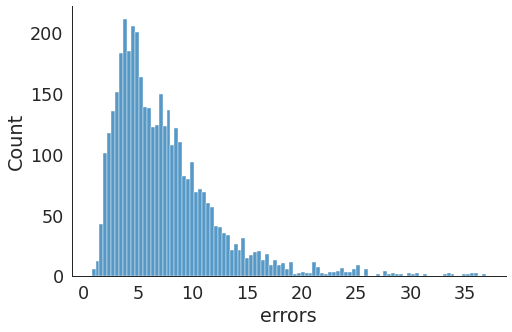

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats
#remove outliers
z_scores = stats.zscore(errors_df)

abs_z_scores = np.abs(z_scores)
filtered_errors = (abs_z_scores < 3).all(axis=1)
new_errors_df = errors_df[filtered_errors]

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=new_errors_df, x="errors", kind="hist", bins = 100, aspect = 1.5)

Find the best distribution (the output ranks the best distributions in ascending order)

,sumsquare_error,aic,bic,kl_div
invgauss,0.003652,1045.083418,-56540.378127,inf
lognorm,0.004042,1031.729537,-56128.141416,inf
gamma,0.005253,1118.291601,-55063.473104,inf
pearson3,0.005253,1118.293200,-55063.445839,inf
beta,0.005629,1098.188982,-54774.958271,inf


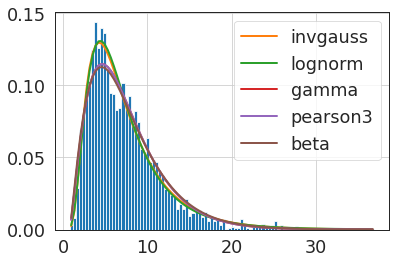

In [10]:
er = new_errors_df["errors"].values

f = Fitter(er,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang'])
f.fit()
f.summary()

# Showing the anomalies found with Mahalanobis distance with tables

The anomaly is shown with the 3 previous values, all the following anomalous values and the following 2 non-anomalous values

> The first anomaly is always the 4-th row



Diplay all the anomalies

In [11]:
index_no = data.columns.get_loc('Predictions')
i=0
while(i<len(data)):
  if(data.iloc[[i],[index_no]].values == 1):
    j=i+1
    if(j>=len(data)):
      break
    else:
       while(data.iloc[[j],[index_no]].values == 1):
          j=j+1
          if(j>=len(data)):
            j=j-1
            break
    for s in range(i,j):
      d=0
      for col in df.columns:
        dis=float(data.iloc[[s],[d]].values-data.iloc[[s-1],[d]].values)
        print(col+':'+str(dis))
        d=d+1
      print ('*' * 20)
    if(i-3<0):
      tmp=data.iloc[i: j + 2]
      display(tmp)
    if(j+2>len(data)):
      tmp=data.iloc[i -3: j]
      display(tmp)
    else:
      tmp=data.iloc[i - 3 : j + 2]
      display(tmp)
    i=j
  else:
    i=i+1     

O3:0.7142857142857224
PM2.5:3.0
CO2:-11.857142857142833
Temp. int.:-5.174285714285716
T:-0.3000000000000007
PM10:2.571428571428573
RH:14.14285714285711
NO2:118.71428571428572
CO:-10.857142857142861
VOC:-34.571428571428555
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-09-30 03:00:00,298.800000,16.000000,457.800000,29.036000,16.860000,18.800000,967.800000,169.800000,230.600000,333.800000,0
2021-09-30 03:10:00,306.800000,16.400000,457.800000,28.934000,16.760000,19.800000,975.400000,175.600000,231.600000,335.400000,0
2021-09-30 03:20:00,322.285714,17.000000,461.857143,28.834286,16.700000,20.428571,983.857143,190.285714,231.857143,338.571429,0
2021-09-30 03:30:00,323.000000,20.000000,450.000000,23.660000,16.400000,23.000000,998.000000,309.000000,221.000000,304.000000,1
2021-09-30 03:40:00,336.333333,20.666667,471.666667,26.666667,16.333333,25.666667,999.000000,255.000000,221.666667,315.000000,0
2021-09-30 03:50:00,351.000000,20.000000,482.500000,28.252500,16.300000,25.000000,999.000000,250.750000,227.250000,323.500000,0


O3:-47.97619047619048
PM2.5:-1.8571428571428577
CO2:-37.833333333333314
Temp. int.:1.1352380952380905
T:2.0
PM10:-5.833333333333332
RH:-141.97619047619048
NO2:-150.16666666666666
CO:-5.166666666666657
VOC:-34.64285714285717
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-09-30 09:00:00,439.500000,19.750000,489.500000,29.637500,17.725000,29.250000,971.750000,305.250000,237.250000,374.500000,0
2021-09-30 09:10:00,428.428571,20.428571,477.857143,30.012857,18.542857,29.000000,945.000000,273.428571,237.285714,368.571429,0
2021-09-30 09:20:00,406.833333,18.000000,465.833333,30.623333,19.500000,25.833333,898.833333,226.166667,234.166667,353.500000,0
2021-09-30 09:30:00,358.857143,16.142857,428.000000,31.758571,21.500000,20.000000,756.857143,76.000000,229.000000,318.857143,1
2021-09-30 09:40:00,319.428571,11.571429,424.142857,32.777143,22.171429,14.000000,712.285714,69.142857,227.142857,314.285714,0
2021-09-30 09:50:00,303.166667,8.333333,422.833333,33.591667,22.833333,10.333333,682.333333,67.833333,225.833333,313.500000,0


Which anamaly do you want to display? (enter a number)

In [ ]:
input_a =int(input("Type the number of the anomaly you want to display:"))
index_no = data.columns.get_loc('Predictions')
cnt=0
i=0
while(i<len(data)):
  if(data.iloc[[i],[index_no]].values == 1):
    cnt=cnt+1
    j=i+1
    while(data.iloc[[j],[index_no]].values == 1):
      j=j+1
    if(input_a == cnt):
      for s in range(i,j):
        d=0
        for col in df.columns:
          dis=float(data.iloc[[s],[d]].values-data.iloc[[s-1],[d]].values)
          print(col+':'+str(dis))
          d=d+1
        print ('*' * 20)
      if(i-3<0):
        tmp=data.iloc[i: j + 2]
        display(tmp)
      if(j+2>len(data)):
        tmp=data.iloc[i: j + 2]
        display(tmp)
      else:
        tmp=data.iloc[i - 3 : j + 2]
        display(tmp)
      i=len(data+1)
    i=j
  else:
    i=i+1    


Type the number of the anomaly you want to display:1
O3:0.7142857142857224
PM2.5:3.0
CO2:-11.857142857142833
Temp. int.:-5.174285714285716
T:-0.3000000000000007
PM10:2.571428571428573
RH:14.14285714285711
NO2:118.71428571428572
CO:-10.857142857142861
VOC:-34.571428571428555
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-09-30 03:00:00,298.800000,16.000000,457.800000,29.036000,16.860000,18.800000,967.800000,169.800000,230.600000,333.800000,0
2021-09-30 03:10:00,306.800000,16.400000,457.800000,28.934000,16.760000,19.800000,975.400000,175.600000,231.600000,335.400000,0
2021-09-30 03:20:00,322.285714,17.000000,461.857143,28.834286,16.700000,20.428571,983.857143,190.285714,231.857143,338.571429,0
2021-09-30 03:30:00,323.000000,20.000000,450.000000,23.660000,16.400000,23.000000,998.000000,309.000000,221.000000,304.000000,1
2021-09-30 03:40:00,336.333333,20.666667,471.666667,26.666667,16.333333,25.666667,999.000000,255.000000,221.666667,315.000000,0
2021-09-30 03:50:00,351.000000,20.000000,482.500000,28.252500,16.300000,25.000000,999.000000,250.750000,227.250000,323.500000,0


# Showing the anomalies found with Mahalanobis distance with graphs

get all the anomalies

In [12]:
anomalies= data[(data['Predictions'] == 1)]

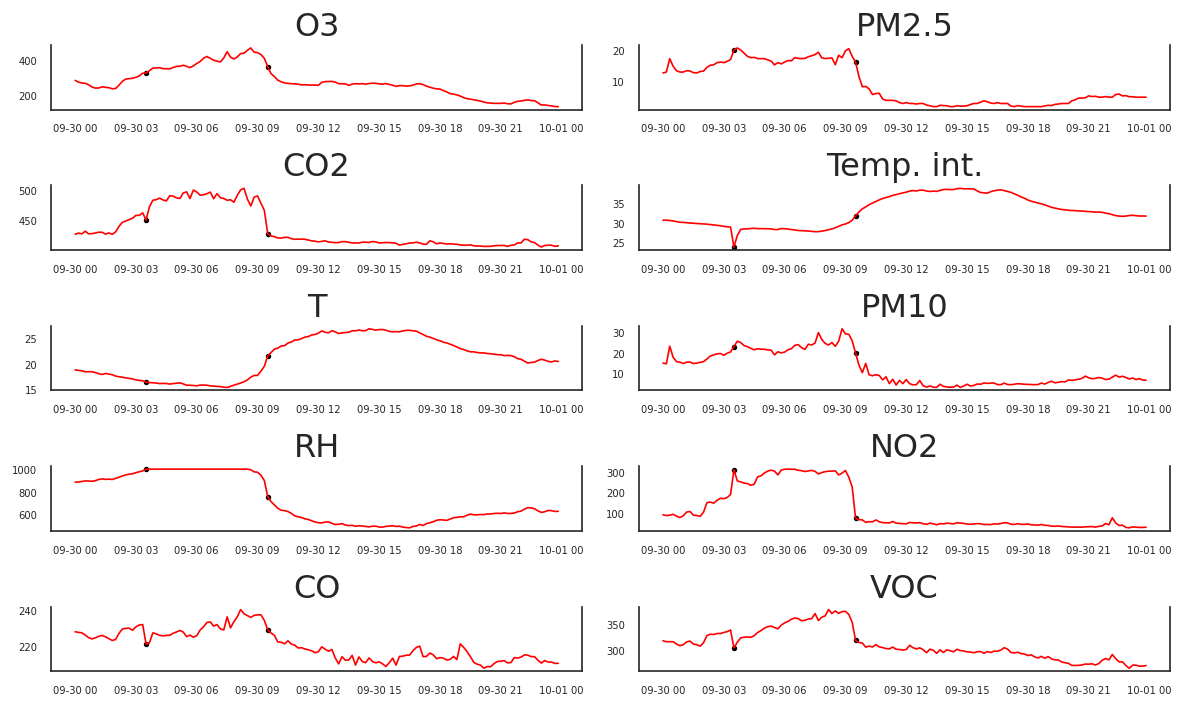

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data_maha = data[df.columns[i]]
    ax.plot(data_maha, color='red', linewidth=1)
    
    # x axis value list.
    x_number_list = list(anomalies.index.values)
    # y axis value list.
    y_number_list = list(anomalies[df.columns[i]].values)
    # Draw point based on above x, y axis values.
    ax.scatter(x_number_list, y_number_list, color='black', s=6)

    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Searching the anomalies using distance from the var model expected values

In [16]:
#var expected values into a df
var_fit_df=pd.DataFrame(var_fitresults.fittedvalues, index=df_copy.index[-(len(df_copy)-selected_lag):], columns=df.columns)



If you need to revert the differencing

In [15]:

#revert the differencing
df_tra= df_copy[0:-selected_lag]
def invert_transformation(df_train, df, second_diff=False):
    """Revert back the differencing to original scale."""
    df_fc = df.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc
res = invert_transformation(df_tra, var_fit_df, second_diff=False)
how_many=144
res=res.iloc[-how_many:,:]
display(res)     


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-09-30 00:10:00,1.279079e+06,19318.625137,1.698452e+06,136880.817760,89715.567209,44340.635594,2.477774e+06,551417.710512,890358.607751,1.294726e+06
2021-09-30 00:20:00,1.279347e+06,19331.264481,1.698882e+06,136911.319883,89734.222619,44354.763348,2.478663e+06,551518.028749,890587.613669,1.295044e+06
2021-09-30 00:30:00,1.279614e+06,19346.575796,1.699311e+06,136941.754595,89752.809625,44373.852851,2.479557e+06,551620.881104,890816.375371,1.295363e+06
2021-09-30 00:40:00,1.279877e+06,19359.331597,1.699744e+06,136972.024711,89771.141757,44388.171311,2.480457e+06,551726.967590,891043.678625,1.295681e+06
2021-09-30 00:50:00,1.280130e+06,19372.532036,1.700172e+06,137002.271801,89789.637567,44403.670631,2.481353e+06,551822.862424,891269.408427,1.295994e+06
...,...,...,...,...,...,...,...,...,...,...
2021-09-30 23:20:00,1.317294e+06,20528.156549,1.759019e+06,141469.972470,92663.818583,46028.094921,2.578496e+06,568386.607749,921027.847876,1.338094e+06
2021-09-30 23:30:00,1.317434e+06,20532.936177,1.759429e+06,141501.755005,92684.174576,46033.063711,2.579136e+06,568423.829634,921239.637717,1.338367e+06
2021-09-30 23:40:00,1.317571e+06,20537.497704,1.759839e+06,141533.468896,92704.510201,46037.511507,2.579769e+06,568459.470932,921451.244859,1.338637e+06


If you did not use the differencing

In [17]:
how_many=144
res=var_fit_df.iloc[-how_many:,:]


Show how accurate the predictions are

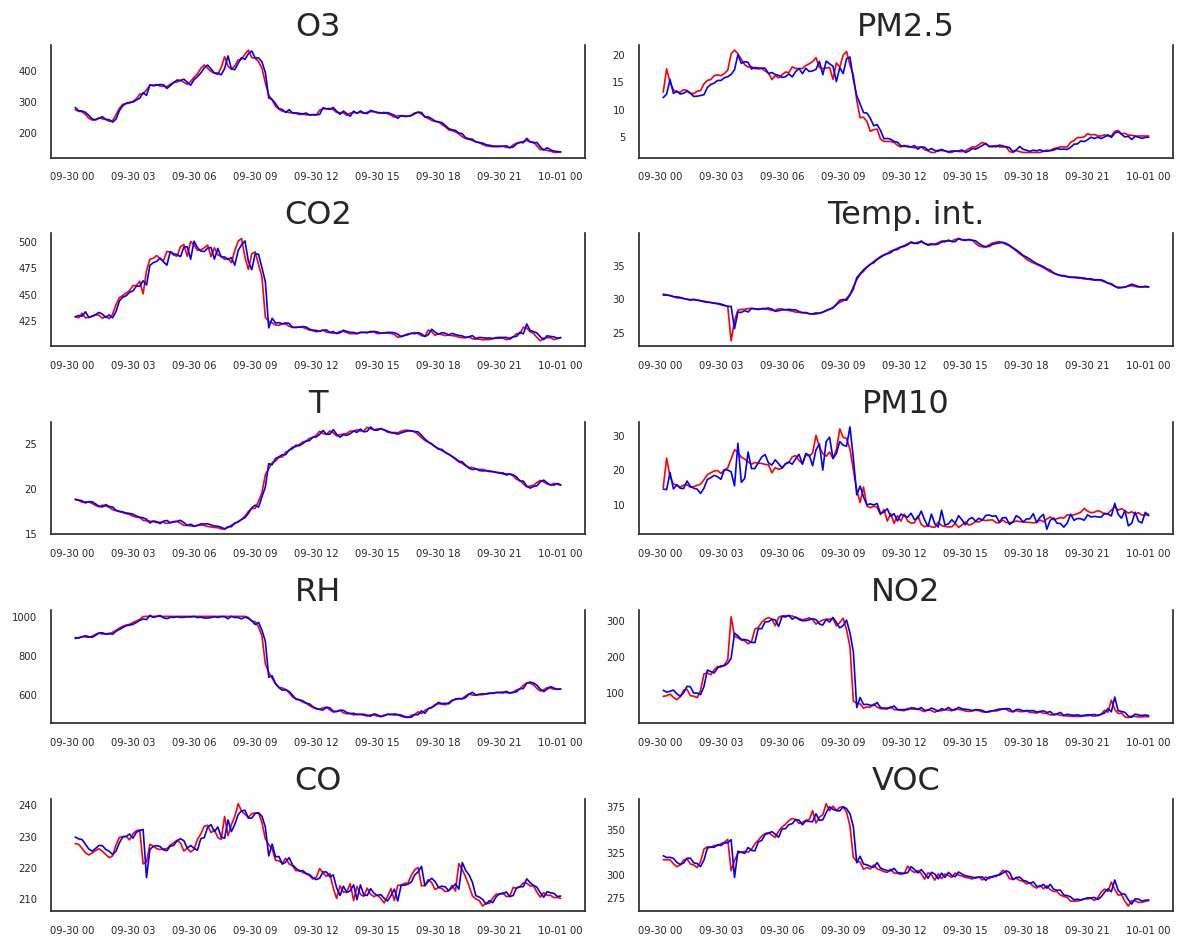

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df_compare=df_copy.iloc[-how_many:,:]

# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,8))
for i, ax in enumerate(axes.flatten()):
    data_2 = df_compare[df.columns[i]]
    data_res=res[res.columns[i]]
    ax.plot(data_2, color='red', linewidth=1)
    ax.plot(data_res, color='blue', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Find distance between predicted values and actual values

In [28]:
import numpy as np
distance = pd.DataFrame(index=df_copy.iloc[-how_many-1:-1,:].index)
usable = df_copy.iloc[-how_many-1:-1,:]
for col in df.columns:
  distance[col]=(usable[col]).values-(res[col]).values


# Testing the distance's distributions

Make histograms

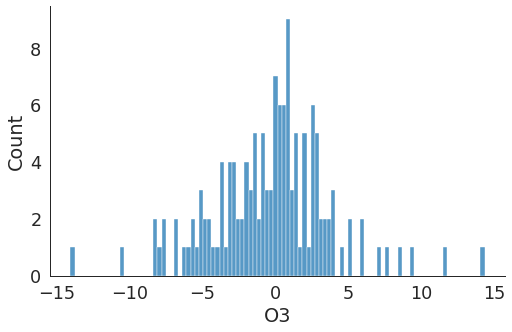

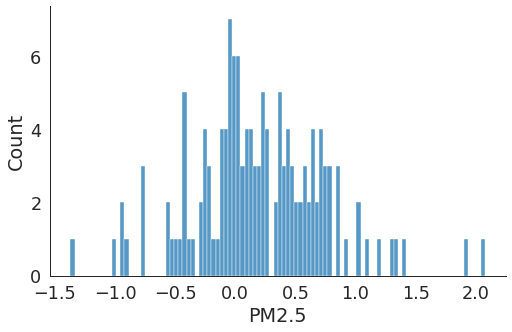

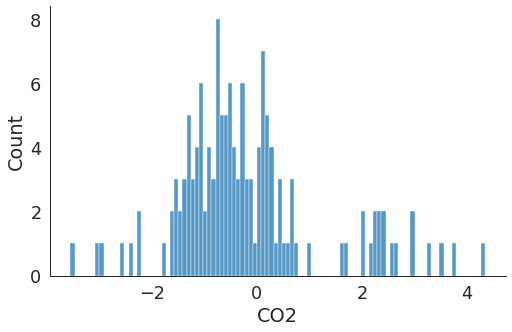

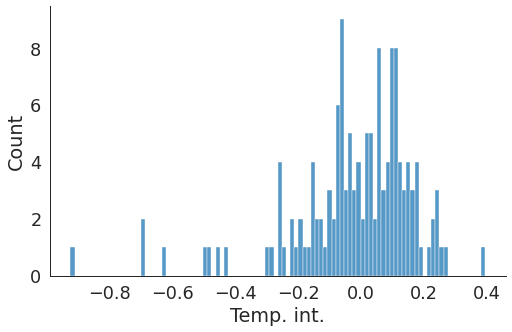

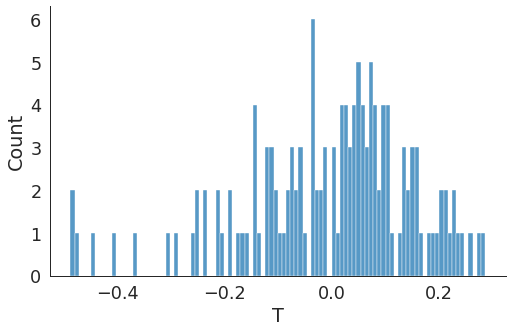

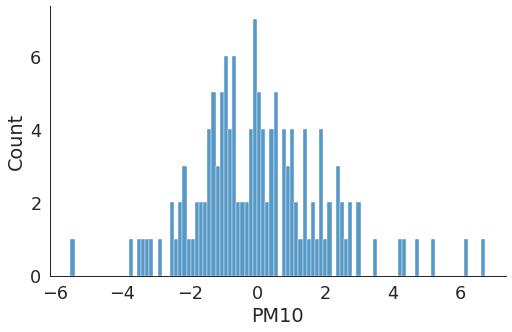

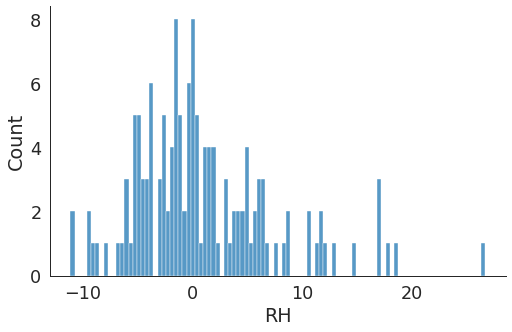

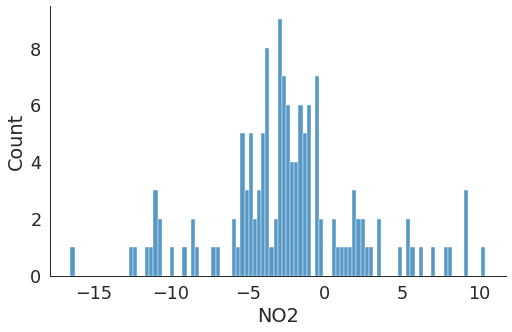

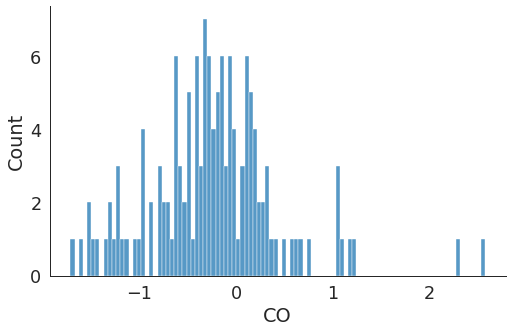

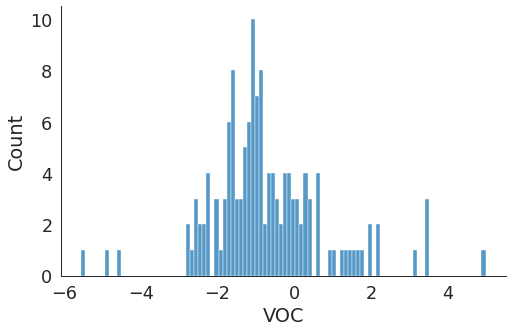

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats


#remove outliers
z_scores = stats.zscore(distance)

abs_z_scores = np.abs(z_scores)
filtered_distance = (abs_z_scores < 3).all(axis=1)
new_distance = distance[filtered_distance]

for col in df.columns:
  sns.set_style('white')
  sns.set_context("paper", font_scale = 2)
  sns.displot(data=new_distance, x=col, kind="hist", bins = 100, aspect = 1.5)

Find the best distribution (the output ranks the best distributions in ascending order)

          sumsquare_error         aic          bic  kl_div
norm             0.085822  879.933094 -1017.334265     inf
beta             0.086301  883.049898 -1006.692004     inf
pearson3         0.086318  881.021027 -1011.599348     inf
lognorm          0.086388  881.286208 -1011.486286     inf
gamma            0.086733  880.297099 -1010.932910     inf


(-0.31399064044845226, 4.03321480248982)

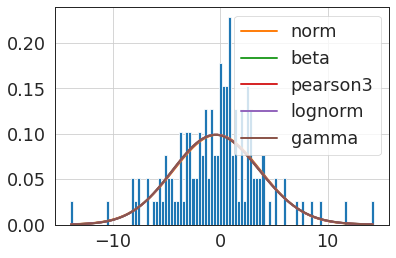

In [22]:
dis = new_distance["O3"].values
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
f.fitted_param["norm"]

          sumsquare_error         aic         bic  kl_div
burr             5.203317  400.707004 -436.901806     inf
lognorm          5.347195  404.726334 -438.044924     inf
gamma            5.350258  405.107116 -437.965324     inf
pearson3         5.350280  405.100655 -437.964758     inf
beta             5.357107  405.941165 -432.853039     inf


(14.178133750629613, 0.7327947427967996, -3.589148525262332, 3.895598429532161)

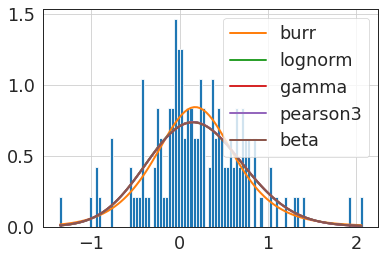

In [37]:
dis = new_distance["PM2.5"].values
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
f.fitted_param["burr"]

          sumsquare_error         aic         bic  kl_div
burr             1.080789  569.716571 -655.354922     inf
lognorm          1.306318  550.055953 -633.945900     inf
invgauss         1.319555  549.084995 -632.544561     inf
gamma            1.341859  547.619038 -630.214656     inf
pearson3         1.341881  547.611475 -630.212356     inf


(8.845492403984462, 1.2912568656336902, -6.897965604706558, 6.27094364045671)

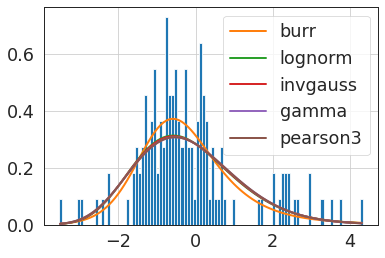

In [38]:
dis = new_distance["CO2"].values
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
f.fitted_param["burr"]

             sumsquare_error         aic         bic  kl_div
weibull_min        42.879602  277.897978 -148.671377     inf
pearson3           45.298825  299.438508 -141.042382     inf
beta               45.391799  298.887306 -135.822909     inf
weibull_max        54.119435  289.536755 -116.312578     inf
norm               55.601975  387.332954 -117.490527     inf


(-0.7472931063413365, -0.020522214631588237, 0.18529746730344615)

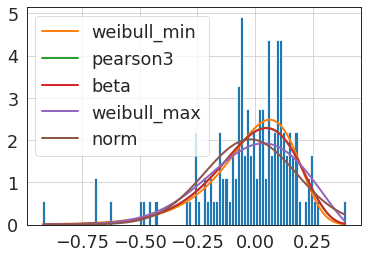

In [40]:
dis = new_distance["Temp. int."].values
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
f.fitted_param["pearson3"]

             sumsquare_error        aic        bic  kl_div
burr               93.840461  41.002500 -34.872120     inf
weibull_min        95.217382  39.186002 -37.781866     inf
pearson3           96.416880  36.185697 -36.041756     inf
beta               96.442563  38.046898 -31.070260     inf
weibull_max        99.568137  29.221239 -31.571389     inf


(24.51089979551176, 0.255406576113279, -1.026884651389296, 1.165670720906802)

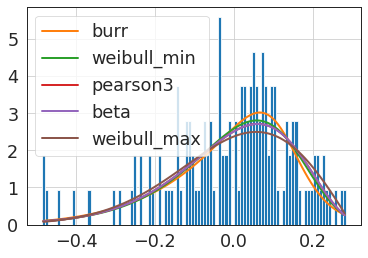

In [41]:
dis = new_distance["T"].values
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
f.fitted_param["burr"]

          sumsquare_error         aic         bic  kl_div
burr             0.343717  651.342647 -814.597265     inf
lognorm          0.355410  667.393251 -814.881591     inf
invgauss         0.357079  666.150163 -814.230447     inf
gamma            0.357625  666.787269 -814.018168     inf
pearson3         0.357626  666.787348 -814.017835     inf


(86919951.36968634, 2.7219399848548047, -122330181.0298676, 122330179.21559542)

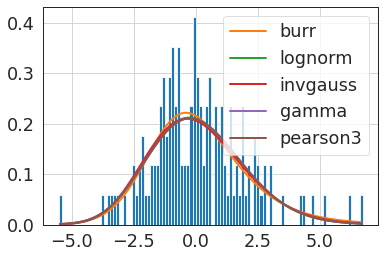

In [42]:
dis = new_distance["PM10"].values
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
f.fitted_param["burr"]

          sumsquare_error         aic          bic  kl_div
burr             0.054471  890.995167 -1070.656857     inf
lognorm          0.057535  887.807519 -1067.983073     inf
invgauss         0.057956  888.504282 -1066.970257     inf
gamma            0.058811  891.648299 -1064.934427     inf
pearson3         0.058811  891.645278 -1064.934031     inf


(7.06749118658287, 1.6331603672917123, -26.227361071646083, 23.863716130781214)

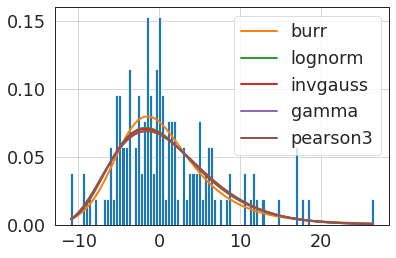

In [43]:
dis = new_distance["RH"].values
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
f.fitted_param["burr"]

          sumsquare_error         aic         bic  kl_div
burr             0.148210  801.549682 -931.522562     inf
lognorm          0.169754  785.502717 -917.591953     inf
pearson3         0.169801  785.229065 -917.553323     inf
beta             0.169809  787.187957 -912.612648     inf
gamma            0.169844  785.847593 -917.517710     inf


(18.716106561573753,
 0.7474870251636517,
 -43.143464383833575,
 41.64550422599457)

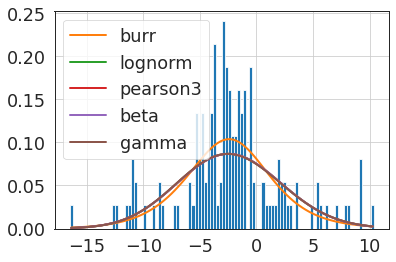

In [44]:
dis = new_distance["NO2"].values
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
f.fitted_param["burr"]

          sumsquare_error         aic         bic  kl_div
burr             3.460483  501.646023 -493.598238     inf
norm             3.940824  549.611199 -485.399742     inf
lognorm          4.070769  485.408609 -475.955809     inf
pearson3         4.078021  489.208072 -475.708428     inf
gamma            4.078086  489.189542 -475.706206     inf


(7.642102625656607, 0.3865188115275313, -2.059534884183878, 2.197328308503412)

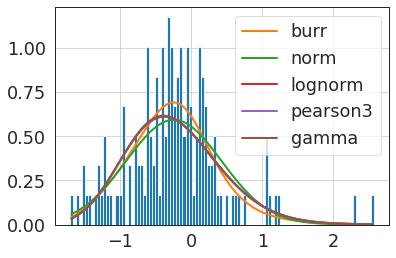

In [45]:
dis = new_distance["CO"].values
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
f.fitted_param["burr"]

          sumsquare_error         aic         bic  kl_div
pearson3         0.674232         NaN -725.879554     inf
lognorm          0.811495  685.275033 -700.122416     inf
invgauss         0.817367  677.381472 -699.120129     inf
beta             0.818786  685.417222 -693.944596     inf
gamma            0.819126  684.662932 -698.821430     inf


(1.0717814837948951, -0.631065045469569, 1.340132404662214)

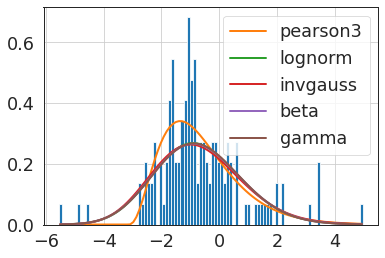

In [46]:
dis = new_distance["VOC"].values
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
f.fitted_param["pearson3"]

# Thresholds and search

Finding anomalies with the normal distribution (O3)

In [61]:
def find_anomalies_norm(errors):
    threshold = 2*(np.std(errors))
    predictions = (errors >= threshold).astype(int)
    return predictions, threshold
predictions_O3, threshold_O3 = find_anomalies_norm(abs(distance['O3']))

how_many=144
data_thresh=df_copy.iloc[-how_many:,:]
data_thresh['Predictions_O3'] = predictions_O3.values
data_thresh['Predictions_O3'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


0    137
1      7
Name: Predictions_O3, dtype: int64

# Showing the anomalies found with the prediction's distance with graphs

In [62]:
anomalies_O3= data_thresh[(data_thresh['Predictions_O3'] == 1)]

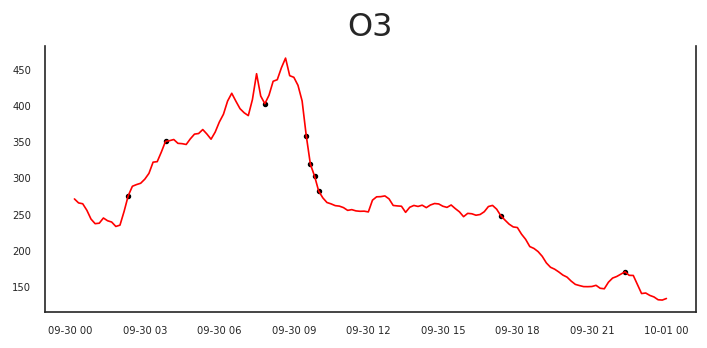

In [56]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, dpi=120, figsize=(6,3))
data_O3 = data_thresh['O3']
ax.plot(data_O3, color='red', linewidth=1)
    
# x axis value list.
x_number_list = list(anomalies_O3.index.values)
# y axis value list.
y_number_list = list(anomalies_O3['O3'].values)
# Draw point based on above x, y axis values.
ax.scatter(x_number_list, y_number_list, color='black', s=6)

# Decorations
ax.set_title('O3')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines["top"].set_alpha(0)
ax.tick_params(labelsize=6)

plt.tight_layout();

# Showing the anomalies using distance from the var model expected values



The anomaly is shown with the 3 previous values, all the following anomalous values and the following 2 non-anomalous values

> The first anomaly is always the 4-th row



Diplay all the anomalies

In [ ]:
index_no = results_pred.columns.get_loc('Predictions')
i=0
while(i<len(results_pred)):
  if(results_pred.iloc[[i],[index_no]].values == 1):
    j=i+1
    if(j>=len(results_pred)):
      break
    else:
       while(results_pred.iloc[[j],[index_no]].values == 1):
          j=j+1
          if(j>=len(results_pred)):
            j=j-1
            break
    for s in range(i,j):
      print(s)
      d=0
      for col in df.columns:
        dis=float(usable.iloc[[s],[d]].values-res.iloc[[s],[d]].values)
        print(col+':'+str(dis))
        d=d+1
      print ('*' * 20)
    if(i-3<0):
      tmp=results_pred.iloc[i: j + 2]
      display(tmp)
    if(j+2>len(results_pred)):
      tmp=results_pred.iloc[i -3: j]
      display(tmp)
    else:
      tmp=results_pred.iloc[i - 3 : j + 2]
      display(tmp)
    i=j
  else:
    i=i+1  

0
O3:-45.91972835619737
PM2.5:-1.5905818298574061
CO2:15.674952888056907
Temp. int.:-2.97321804004833
T:-2.805174324349167
PM10:-3.6048899269135357
RH:-37.55452021185022
NO2:66.6220462486614
CO:-14.015376636292018
VOC:6.204110163647272
********************
1
O3:-50.028256004730736
PM2.5:-1.884033278214158
CO2:11.359267567015138
Temp. int.:-2.858398903340145
T:-2.551777298457619
PM10:-4.45280289560778
RH:-41.23580376783491
NO2:9.047952985542906
CO:-16.20228599253622
VOC:-3.1432250842793223
********************
2
O3:-54.94867045098209
PM2.5:-1.467319045235663
CO2:8.642310435141098
Temp. int.:-2.8659033819683373
T:-2.5048950216926826
PM10:-4.163397191250084
RH:-44.50671145034278
NO2:1.1154870939591603
CO:-16.860542817407236
VOC:-6.37516582279676
********************
3
O3:-63.78703452040975
PM2.5:-1.1945317332514063
CO2:6.63461416639575
Temp. int.:-3.1199019901976257
T:-2.586073548211136
PM10:-4.305372289797125
RH:-46.983785119477716
NO2:0.02047201249345676
CO:-18.691167529236935
VOC:-9.62

,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-07-10 01:00:00,301.833333,1.000000,420.500000,33.298333,20.183333,3.833333,549.166667,260.833333,213.500000,343.666667,1,347.753062,2.590582,404.825047,36.271551,22.988508,7.438223,586.721187,194.211287,227.515377,337.462557
2021-07-10 01:10:00,290.714286,1.000000,413.285714,33.204286,20.371429,3.285714,542.714286,215.000000,211.857143,334.142857,1,340.742542,2.884033,401.926447,36.062685,22.923206,7.738517,583.950089,205.952047,228.059429,337.286082
2021-07-10 01:20:00,292.000000,1.000000,415.285714,33.090000,20.085714,3.714286,554.142857,239.428571,213.000000,338.428571,1,346.948670,2.467319,406.643404,35.955903,22.590609,7.877683,598.649569,238.313084,229.860543,344.803737
2021-07-10 01:30:00,283.666667,1.000000,411.666667,33.041667,20.233333,3.000000,546.833333,211.166667,211.333333,332.333333,1,347.453701,2.194532,405.032053,36.161569,22.819407,7.305372,593.817118,211.146195,230.024501,341.961098
2021-07-10 01:40:00,280.000000,1.000000,409.285714,33.022857,20.242857,2.857143,548.142857,211.000000,211.285714,331.857143,1,348.464101,1.540686,409.202336,36.132698,22.661131,7.082178,598.564096,253.595333,230.777439,348.415701
2021-07-10 01:50:00,277.000000,1.000000,411.400000,32.860000,19.940000,3.400000,559.200000,207.200000,210.000000,329.400000,1,350.950134,1.926479,414.620248,36.086195,22.488045,8.112584,607.200118,267.034461,230.543213,351.139006
2021-07-10 02:00:00,276.285714,1.000000,413.285714,32.737143,19.771429,2.428571,567.285714,217.285714,211.571429,332.000000,1,352.226050,1.880292,414.002528,36.281023,22.843673,6.809006,594.218682,278.867335,231.727558,354.326583
2021-07-10 02:10:00,275.714286,1.000000,414.142857,32.610000,19.514286,3.571429,577.428571,213.285714,211.428571,330.000000,1,349.765062,2.295200,413.426064,36.223012,22.584546,8.646297,598.974313,258.133266,229.497671,348.538927
2021-07-10 02:20:00,269.666667,1.000000,410.500000,32.428333,19.483333,3.333333,572.833333,202.166667,210.166667,327.166667,1,346.144962,2.086701,407.679687,35.796267,22.933958,6.613123,589.852161,251.465679,230.708900,347.292960


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,


21
O3:-57.17718667858725
PM2.5:-0.013425166438308489
CO2:28.60334442161559
Temp. int.:-4.409194643746574
T:-5.3864112094287435
PM10:-2.1022643949758137
RH:76.27785416120787
NO2:179.2502191572675
CO:-11.828776220277177
VOC:7.270666661584926
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-07-10 04:00:00,260.714286,1.714286,421.714286,31.098571,17.814286,4.571429,635.714286,308.714286,212.428571,324.000000,1,347.352562,3.207194,412.471478,37.060776,22.477689,8.090435,598.332672,228.462524,233.769171,359.688291
2021-07-10 04:10:00,265.333333,2.000000,424.333333,31.015000,17.566667,4.666667,641.000000,312.666667,212.333333,326.000000,0,343.511443,2.643964,406.617900,36.437403,22.619013,6.926470,584.343279,176.917720,228.278727,342.490164
2021-07-10 04:20:00,274.857143,1.857143,426.285714,30.898571,17.457143,4.285714,654.000000,349.571429,214.142857,334.000000,0,345.333579,2.023183,402.309651,35.729199,22.783238,6.320650,591.541631,206.517971,229.319441,341.379931
2021-07-10 04:30:00,285.666667,1.666667,432.500000,30.766667,17.316667,4.500000,660.333333,349.666667,215.000000,335.833333,1,342.843853,1.680092,403.896656,35.175861,22.703078,6.602264,584.055479,170.416448,226.828776,328.562667
2021-07-10 04:40:00,293.166667,1.833333,433.166667,30.655000,17.116667,4.666667,680.500000,317.333333,216.166667,335.000000,0,336.459349,1.722146,396.124830,34.783435,22.577390,6.125431,597.815976,145.231973,225.544034,320.847345
2021-07-10 04:50:00,294.333333,1.500000,421.666667,30.638333,17.333333,4.833333,691.166667,283.000000,218.333333,332.666667,0,330.833788,1.078871,384.348159,34.907745,22.929030,5.956578,587.067229,164.404045,225.261770,319.792283


27
O3:-44.81721825299286
PM2.5:0.4342369487842317
CO2:43.05082411573835
Temp. int.:-5.02310683687562
T:-5.6849398242592954
PM10:-2.743640596080917
RH:103.43869005988006
NO2:206.19868413444624
CO:-8.69382715471852
VOC:20.517335524080636
********************
28
O3:-25.444039032702108
PM2.5:0.05394456368167999
CO2:56.24669533164189
Temp. int.:-5.382599499553052
T:-5.654269855884355
PM10:-3.045046816511526
RH:97.40727421693441
NO2:236.81811640738235
CO:-7.669988254506933
VOC:24.46057281156834
********************
29
O3:-22.710036086286493
PM2.5:0.26203574791715045
CO2:55.03579441390491
Temp. int.:-5.93412507326855
T:-6.053896646051136
PM10:-3.380814889116283
RH:91.17865116234577
NO2:219.75870562890913
CO:-7.706586584174545
VOC:19.224846671192097
********************
30
O3:-26.253815862162924
PM2.5:0.8757984323897166
CO2:47.54783636313914
Temp. int.:-6.313469045381531
T:-6.1727018111579035
PM10:-1.7071613925920133
RH:93.72300487907171
NO2:191.47546210230664
CO:-6.671109992953973
VOC:12.8405

,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-07-10 05:00:00,289.666667,1.000000,420.500000,30.638333,17.566667,4.666667,663.500000,273.666667,214.000000,329.833333,0,333.181339,1.835163,393.396824,34.924443,23.086696,7.076067,564.026351,198.140436,223.391671,322.229107
2021-07-10 05:10:00,289.142857,1.142857,425.857143,30.600000,17.242857,4.428571,679.000000,271.714286,213.428571,329.857143,0,332.969015,1.338364,398.273428,35.171095,22.642200,5.330183,591.877304,194.331105,225.009410,326.531207
2021-07-10 05:20:00,291.857143,2.000000,433.000000,30.458571,17.100000,5.142857,692.428571,369.714286,217.428571,345.000000,0,340.113507,2.186356,397.228136,35.023524,22.590129,7.882586,602.681613,246.316886,231.317727,335.416755
2021-07-10 05:30:00,308.333333,1.833333,448.666667,30.320000,16.900000,5.000000,699.000000,397.166667,219.000000,350.833333,1,353.150552,1.399096,405.615843,35.343107,22.584940,7.743641,595.561310,190.967983,227.693827,330.315998
2021-07-10 05:40:00,316.714286,1.857143,452.714286,30.170000,16.800000,4.857143,690.857143,395.428571,217.142857,351.714286,1,342.158325,1.803198,396.467590,35.552599,22.454270,7.902190,593.449869,158.610455,224.812845,327.253713
2021-07-10 05:50:00,314.166667,1.666667,449.666667,29.995000,16.616667,5.166667,695.166667,378.166667,216.500000,347.833333,1,336.876703,1.404631,394.630872,35.929125,22.670563,8.547482,603.988016,158.407961,224.206587,328.608487
2021-07-10 06:00:00,317.285714,5.571429,439.857143,29.884286,16.485714,9.857143,693.857143,370.571429,219.857143,350.285714,1,343.539530,4.695630,392.309306,36.197755,22.658416,11.564304,600.134138,179.095966,226.528253,337.445136
2021-07-10 06:10:00,304.200000,1.400000,433.600000,29.780000,16.420000,4.200000,699.600000,332.000000,216.400000,339.400000,1,330.923494,-2.272459,396.673441,36.313111,22.774958,2.126486,611.839043,158.670988,220.411665,328.005312
2021-07-10 06:20:00,304.714286,2.142857,429.285714,30.138571,16.971429,5.857143,676.285714,321.428571,224.285714,343.857143,0,337.999880,2.684502,398.764569,36.586576,22.984621,9.066774,589.909958,198.849430,228.972973,341.341533


36
O3:-23.740542273539347
PM2.5:4.839677215983674
CO2:26.06666969287386
Temp. int.:-4.1404516660451485
T:-3.7640092703514085
PM10:4.693107660725219
RH:21.404068457903122
NO2:143.77277904990794
CO:0.5904851768024173
VOC:10.862244517172144
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-07-10 06:30:00,309.714286,1.571429,430.428571,30.808571,17.714286,4.571429,659.714286,337.000000,224.285714,346.714286,0,339.324094,0.892874,406.293667,36.372010,22.933078,6.124888,598.747368,225.433121,219.317998,335.386752
2021-07-10 06:40:00,315.833333,2.500000,431.166667,31.318333,18.066667,5.666667,651.333333,342.666667,226.833333,349.500000,0,345.253695,2.056306,407.716858,36.225540,22.598086,7.777233,610.219296,235.094547,223.092523,340.874169
2021-07-10 06:50:00,322.142857,6.285714,433.142857,31.624286,18.157143,11.285714,649.571429,376.000000,225.142857,353.571429,0,346.273328,3.999468,408.839316,36.148013,22.319151,11.238416,622.174202,249.866538,222.662298,343.187393
2021-07-10 07:00:00,323.833333,2.500000,433.000000,31.885000,18.583333,5.833333,637.333333,386.666667,223.833333,354.333333,1,347.573876,-2.339677,406.933330,36.025452,22.347343,1.140226,615.929265,242.893888,223.242848,343.471089
2021-07-10 07:10:00,311.000000,2.000000,439.333333,32.183333,18.883333,5.333333,626.666667,322.500000,224.833333,356.000000,0,338.284602,2.354240,412.554975,36.167308,22.024463,7.402182,621.556501,194.673688,226.677203,347.939255
2021-07-10 07:20:00,314.571429,1.285714,430.142857,32.342857,19.257143,5.142857,614.571429,331.428571,219.857143,348.714286,0,350.622428,2.620988,397.074262,35.885465,22.147182,7.748745,619.697865,263.329023,222.407775,339.832286


39
O3:-24.8699369190237
PM2.5:-2.2692387816775685
CO2:23.729347778125998
Temp. int.:-3.0835710806962666
T:-2.313515841863161
PM10:-3.5806942084179587
RH:-18.008017858380526
NO2:82.92002425670424
CO:-6.308750357638445
VOC:4.70568210049322
********************
40
O3:-17.82957169421138
PM2.5:-2.700177220693615
CO2:20.93160680321256
Temp. int.:-3.059348782704106
T:-2.196697395265698
PM10:-5.078503064524052
RH:-32.36014790424804
NO2:60.50366209760281
CO:-6.7475127804501085
VOC:1.2606930106911705
********************
41
O3:-16.698103791922392
PM2.5:-1.660223947160189
CO2:19.699277487555605
Temp. int.:-2.918332042994102
T:-2.185159937174756
PM10:-4.884722696764822
RH:-32.77121324574102
NO2:61.32747976665945
CO:-6.549931622626701
VOC:4.527820724897481
********************
42
O3:-15.587395175115546
PM2.5:-1.679215805227508
CO2:18.236268657273115
Temp. int.:-2.825377923906146
T:-2.241402121381114
PM10:-4.417421836320171
RH:-34.81708298051467
NO2:62.63492484599692
CO:-7.426030541880834
VOC:5.0142

,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-07-10 07:00:00,323.833333,2.500000,433.000000,31.885000,18.583333,5.833333,637.333333,386.666667,223.833333,354.333333,1,347.573876,-2.339677,406.933330,36.025452,22.347343,1.140226,615.929265,242.893888,223.242848,343.471089
2021-07-10 07:10:00,311.000000,2.000000,439.333333,32.183333,18.883333,5.333333,626.666667,322.500000,224.833333,356.000000,0,338.284602,2.354240,412.554975,36.167308,22.024463,7.402182,621.556501,194.673688,226.677203,347.939255
2021-07-10 07:20:00,314.571429,1.285714,430.142857,32.342857,19.257143,5.142857,614.571429,331.428571,219.857143,348.714286,0,350.622428,2.620988,397.074262,35.885465,22.147182,7.748745,619.697865,263.329023,222.407775,339.832286
2021-07-10 07:30:00,319.000000,1.166667,429.333333,32.486667,19.300000,5.166667,599.000000,309.333333,217.833333,344.000000,1,343.869937,3.435905,405.603986,35.570238,21.613516,8.747361,617.008018,226.413309,224.142084,339.294318
2021-07-10 07:40:00,318.428571,1.857143,429.000000,32.638571,19.400000,5.142857,598.428571,311.571429,218.428571,346.142857,1,336.258143,4.557320,408.068393,35.697920,21.596697,10.221360,630.788719,251.067766,225.176084,344.882164
2021-07-10 07:50:00,317.833333,1.666667,428.666667,32.628333,19.433333,5.000000,596.166667,304.166667,216.833333,345.500000,1,334.531437,3.326891,408.967389,35.546665,21.618493,9.884723,628.937880,242.839187,223.383265,340.972179
2021-07-10 08:00:00,316.600000,1.600000,424.800000,32.806000,19.800000,6.000000,589.400000,296.000000,218.000000,346.800000,1,332.187395,3.279216,406.563731,35.631378,22.041402,10.417422,624.217083,233.365075,225.426031,341.785769
2021-07-10 08:10:00,322.714286,1.571429,423.142857,33.215714,20.328571,5.428571,571.000000,299.428571,219.000000,351.714286,0,337.808037,2.826776,408.253427,35.692168,21.935941,8.180060,613.889643,243.218743,223.343727,341.344905
2021-07-10 08:20:00,325.500000,1.333333,421.833333,33.690000,20.850000,4.666667,555.166667,282.000000,218.666667,349.833333,0,335.060424,1.882085,407.751446,35.881932,22.046244,7.513673,611.705959,219.578983,220.808837,333.846896


45
O3:-19.280646361864513
PM2.5:-1.1451200462230497
CO2:12.499601996381443
Temp. int.:-1.8317891047710333
T:-0.982717299460429
PM10:-4.351444096857659
RH:-75.08141464622975
NO2:23.399972303705653
CO:-4.469112338405836
VOC:6.353218369105605
********************
46
O3:-30.42498875353334
PM2.5:-1.925326180794662
CO2:5.416617761504483
Temp. int.:-1.6909385060459527
T:-0.9178942475900733
PM10:-5.353303932732353
RH:-82.2380790771532
NO2:-17.767893523885874
CO:-9.019087783279048
VOC:-3.7335616497877595
********************
47
O3:-32.15228889725404
PM2.5:-0.8871598288079197
CO2:3.341829893998863
Temp. int.:-1.1929664970987162
T:-0.7618415638996936
PM10:-4.321861539072315
RH:-90.52489479424457
NO2:-21.109258270919184
CO:-8.472754973174403
VOC:-1.763666277182324
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-07-10 08:00:00,316.600000,1.600000,424.800000,32.806000,19.800000,6.000000,589.400000,296.000000,218.000000,346.800000,1,332.187395,3.279216,406.563731,35.631378,22.041402,10.417422,624.217083,233.365075,225.426031,341.785769
2021-07-10 08:10:00,322.714286,1.571429,423.142857,33.215714,20.328571,5.428571,571.000000,299.428571,219.000000,351.714286,0,337.808037,2.826776,408.253427,35.692168,21.935941,8.180060,613.889643,243.218743,223.343727,341.344905
2021-07-10 08:20:00,325.500000,1.333333,421.833333,33.690000,20.850000,4.666667,555.166667,282.000000,218.666667,349.833333,0,335.060424,1.882085,407.751446,35.881932,22.046244,7.513673,611.705959,219.578983,220.808837,333.846896
2021-07-10 08:30:00,319.285714,1.000000,417.714286,33.965714,20.942857,4.571429,548.857143,258.714286,217.000000,343.285714,1,338.566361,2.145120,405.214684,35.797503,21.925574,8.922873,623.938558,235.314313,221.469112,336.932496
2021-07-10 08:40:00,313.000000,1.000000,413.666667,34.106667,21.016667,4.166667,541.500000,239.666667,216.166667,341.666667,1,343.424989,2.925326,408.250049,35.797605,21.934561,9.519971,623.738079,257.434560,225.185754,345.400228
2021-07-10 08:50:00,314.285714,1.142857,413.571429,34.577143,21.614286,4.285714,532.428571,237.571429,217.571429,344.857143,1,346.438003,2.030017,410.229599,35.770109,22.376127,8.607576,622.953466,258.680687,226.044184,346.620809
2021-07-10 09:00:00,310.571429,1.000000,415.571429,34.825714,21.942857,4.857143,521.285714,230.857143,216.857143,342.428571,0,342.188972,1.407380,409.278511,35.725398,22.220664,8.180114,619.567121,251.896149,224.564610,343.286376
2021-07-10 09:10:00,309.666667,1.000000,410.000000,35.180000,22.216667,3.833333,515.000000,217.500000,219.500000,343.500000,1,344.994486,2.132128,405.816847,35.546524,22.118178,7.716508,623.460255,268.740869,224.828394,346.907243


49
O3:-35.32781926808855
PM2.5:-1.1321275877143453
CO2:4.183153010474712
Temp. int.:-0.3665241508528112
T:0.09848859850852776
PM10:-3.8831743456423813
RH:-108.46025487729776
NO2:-51.240869280854554
CO:-5.328393556491051
VOC:-3.4072425225174356
********************
50
O3:-26.809634110445927
PM2.5:-1.5392883457515656
CO2:1.56824041567819
Temp. int.:0.3886999749473361
T:0.891247366152168
PM10:-4.7012310382673785
RH:-115.65801908145357
NO2:-43.85153726103809
CO:-2.0025616924839085
VOC:3.4639771017998555
********************
51
O3:-17.36607040132327
PM2.5:-1.038599854468476
CO2:3.267285811213185
Temp. int.:0.5010469876120638
T:1.4402576853841111
PM10:-3.6190613306814505
RH:-118.65690799536941
NO2:-15.993788915550795
CO:-3.4142471283270766
VOC:4.226891989887747
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-07-10 08:40:00,313.000000,1.000000,413.666667,34.106667,21.016667,4.166667,541.500000,239.666667,216.166667,341.666667,1,343.424989,2.925326,408.250049,35.797605,21.934561,9.519971,623.738079,257.434560,225.185754,345.400228
2021-07-10 08:50:00,314.285714,1.142857,413.571429,34.577143,21.614286,4.285714,532.428571,237.571429,217.571429,344.857143,1,346.438003,2.030017,410.229599,35.770109,22.376127,8.607576,622.953466,258.680687,226.044184,346.620809
2021-07-10 09:00:00,310.571429,1.000000,415.571429,34.825714,21.942857,4.857143,521.285714,230.857143,216.857143,342.428571,0,342.188972,1.407380,409.278511,35.725398,22.220664,8.180114,619.567121,251.896149,224.564610,343.286376
2021-07-10 09:10:00,309.666667,1.000000,410.000000,35.180000,22.216667,3.833333,515.000000,217.500000,219.500000,343.500000,1,344.994486,2.132128,405.816847,35.546524,22.118178,7.716508,623.460255,268.740869,224.828394,346.907243
2021-07-10 09:20:00,318.571429,1.000000,413.428571,35.702857,22.942857,4.571429,507.714286,234.571429,219.142857,347.000000,1,345.381063,2.539288,411.860331,35.314157,22.051610,9.272660,623.372305,278.422966,221.145419,343.536023
2021-07-10 09:30:00,321.833333,1.000000,413.500000,36.038333,22.983333,4.500000,502.666667,225.333333,218.333333,346.000000,1,339.199404,2.038600,410.232714,35.537286,21.543076,8.119061,621.323575,241.327122,221.747580,341.773108
2021-07-10 09:40:00,334.000000,1.000000,414.714286,36.481429,23.585714,5.142857,490.428571,234.285714,220.714286,352.142857,0,340.293105,1.896168,408.196534,35.527184,21.992517,7.656410,618.669416,248.288581,223.922853,344.946641
2021-07-10 09:50:00,334.428571,1.428571,413.000000,37.121429,24.328571,5.571429,478.428571,233.428571,222.571429,355.000000,1,326.277982,1.611873,403.089888,35.330243,21.552420,6.234508,620.898057,216.669956,220.082002,332.828655


53
O3:8.150589013516878
PM2.5:-0.1833013601426583
CO2:9.91011195643398
Temp. int.:1.7911854908243043
T:2.7761515140725166
PM10:-0.6630790786738627
RH:-142.46948603576277
NO2:16.75861544529758
CO:2.4894269499196184
VOC:22.17134485626866
********************
54
O3:18.47311343828767
PM2.5:-0.4186887950406428
CO2:10.019235341337378
Temp. int.:3.2783394838156354
T:4.304771715783275
PM10:-1.7651573155980422
RH:-171.94469809225865
NO2:24.659483531689034
CO:5.169054582294052
VOC:28.861491563041284
********************
55
O3:43.19230121664799
PM2.5:0.515847328212991
CO2:8.77928435888822
Temp. int.:4.5687399281072345
T:6.0292888714260044
PM10:-1.6069442932380111
RH:-209.38356811787725
NO2:43.633485793430765
CO:6.261208301551079
VOC:37.827910434107594
********************
56
O3:60.54396848081052
PM2.5:0.4426114474513636
CO2:11.507619667362746
Temp. int.:5.480221083489596
T:6.368926524103863
PM10:-2.602000320784903
RH:-222.6354416599571
NO2:22.44142307065769
CO:3.388460233198913
VOC:37.86694841344

,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-07-10 09:20:00,318.571429,1.000000,413.428571,35.702857,22.942857,4.571429,507.714286,234.571429,219.142857,347.000000,1,345.381063,2.539288,411.860331,35.314157,22.051610,9.272660,623.372305,278.422966,221.145419,343.536023
2021-07-10 09:30:00,321.833333,1.000000,413.500000,36.038333,22.983333,4.500000,502.666667,225.333333,218.333333,346.000000,1,339.199404,2.038600,410.232714,35.537286,21.543076,8.119061,621.323575,241.327122,221.747580,341.773108
2021-07-10 09:40:00,334.000000,1.000000,414.714286,36.481429,23.585714,5.142857,490.428571,234.285714,220.714286,352.142857,0,340.293105,1.896168,408.196534,35.527184,21.992517,7.656410,618.669416,248.288581,223.922853,344.946641
2021-07-10 09:50:00,334.428571,1.428571,413.000000,37.121429,24.328571,5.571429,478.428571,233.428571,222.571429,355.000000,1,326.277982,1.611873,403.089888,35.330243,21.552420,6.234508,620.898057,216.669956,220.082002,332.828655
2021-07-10 10:00:00,354.833333,1.666667,413.000000,38.486667,25.750000,5.500000,448.833333,249.500000,224.166667,364.333333,1,336.360220,2.085355,402.980765,35.208327,21.445228,7.265157,620.778031,224.840516,218.997612,335.471842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-10 20:50:00,351.714286,1.000000,398.857143,39.342857,26.614286,4.142857,404.857143,196.714286,218.571429,359.000000,1,343.804931,1.214969,394.873596,36.462358,24.139050,6.892232,601.482425,171.221028,229.192900,334.724314
2021-07-10 21:00:00,350.333333,1.000000,397.333333,39.046667,26.266667,4.333333,429.333333,188.000000,221.666667,355.666667,1,337.540264,1.240149,393.490155,36.445974,24.045461,7.628625,591.461956,162.296621,226.386688,330.575931
2021-07-10 21:10:00,349.571429,1.142857,399.714286,38.900000,26.042857,4.571429,451.428571,207.428571,225.000000,356.714286,1,334.653815,1.370762,392.913721,36.215639,24.114771,8.146896,580.529192,173.699646,226.061198,332.805154


129
O3:17.9382749170382
PM2.5:-0.5021503004032644
CO2:7.0351191728590265
Temp. int.:1.4164693211420172
T:0.6142538621914078
PM10:-3.466846116393313
RH:-63.55960936622159
NO2:34.13117150825008
CO:-4.093240380124541
VOC:15.970587655150496
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-07-10 22:00:00,354.285714,1.000000,399.714286,37.922857,24.914286,5.142857,509.571429,214.714286,234.857143,355.714286,0,336.351890,1.889583,398.624343,36.199604,23.767077,7.433515,588.451646,164.510356,224.461924,330.110370
2021-07-10 22:10:00,346.666667,1.000000,401.000000,37.733333,24.783333,4.166667,507.166667,200.833333,230.333333,350.000000,0,328.687507,1.585966,397.482580,36.143797,24.068920,6.918174,582.137320,141.856043,228.336111,327.232620
2021-07-10 22:20:00,347.857143,1.000000,400.571429,37.542857,24.571429,4.285714,522.714286,196.571429,230.428571,349.142857,0,331.003947,1.152856,396.656962,36.010344,23.436472,7.581450,605.297894,153.526680,233.224176,330.981398
2021-07-10 22:30:00,349.571429,1.000000,404.142857,37.262857,24.000000,4.142857,541.857143,203.428571,229.571429,347.857143,1,331.633154,1.502150,397.107738,35.846388,23.385746,7.609703,605.416752,169.297400,233.664669,331.886555
2021-07-10 22:40:00,350.666667,1.166667,407.333333,36.946667,23.566667,4.833333,546.500000,219.166667,228.000000,347.666667,0,331.699489,1.205263,396.515982,35.582145,23.190664,7.647323,608.180787,175.359352,235.293851,333.481335
2021-07-10 22:50:00,347.714286,1.571429,410.142857,36.600000,23.200000,6.000000,553.857143,223.571429,225.571429,345.000000,0,330.304854,1.295262,393.876321,35.298060,23.507746,7.444209,605.939962,173.493347,233.876239,330.771385


133
O3:22.830649843537685
PM2.5:5.98539043498363
CO2:10.030075425590951
Temp. int.:-0.011457731602355636
T:-0.9327541435753126
PM10:5.2011135994427775
RH:15.678576020472406
NO2:62.4847489472499
CO:-0.887134288906168
VOC:13.301415475978388
********************
134
O3:36.01604768376154
PM2.5:10.159732129121373
CO2:7.518598941915002
Temp. int.:-0.3486045666843154
T:-1.2117334645515534
PM10:8.580675820357087
RH:50.83587455628401
NO2:77.98463959458584
CO:4.202490811140478
VOC:18.411558313730097
********************
135
O3:32.12600240522255
PM2.5:4.350237798638952
CO2:2.7582944563949354
Temp. int.:-0.6697548402890519
T:-1.4248933443379634
PM10:2.91955135550782
RH:77.06354491947138
NO2:82.50283049409418
CO:3.6316313953253427
VOC:15.088920713718665
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-07-10 22:40:00,350.666667,1.166667,407.333333,36.946667,23.566667,4.833333,546.500000,219.166667,228.000000,347.666667,0,331.699489,1.205263,396.515982,35.582145,23.190664,7.647323,608.180787,175.359352,235.293851,333.481335
2021-07-10 22:50:00,347.714286,1.571429,410.142857,36.600000,23.200000,6.000000,553.857143,223.571429,225.571429,345.000000,0,330.304854,1.295262,393.876321,35.298060,23.507746,7.444209,605.939962,173.493347,233.876239,330.771385
2021-07-10 23:00:00,347.833333,2.333333,408.833333,36.250000,22.900000,7.500000,585.833333,229.333333,228.333333,344.333333,0,334.139796,1.381195,393.684133,35.548630,23.575565,6.841256,616.488291,184.420317,236.327798,335.052392
2021-07-10 23:10:00,363.000000,8.285714,407.857143,35.900000,22.457143,12.428571,623.000000,252.285714,234.285714,350.000000,1,340.169350,2.300324,397.827067,35.911458,23.389897,7.227458,607.321424,189.800965,235.172849,336.698585
2021-07-10 23:20:00,364.285714,3.285714,405.428571,35.588571,22.300000,7.857143,650.000000,239.142857,234.857143,346.714286,1,328.269667,-6.874018,397.909972,35.937176,23.511733,-0.723533,599.164125,161.158218,230.654652,328.302727
2021-07-10 23:30:00,353.833333,2.000000,400.833333,35.540000,22.566667,5.666667,646.666667,235.166667,236.000000,344.833333,1,321.707331,-2.350238,398.075039,36.209755,23.991560,2.747115,569.603122,152.663836,232.368369,329.744413
2021-07-10 23:40:00,354.857143,2.000000,404.857143,35.608571,22.728571,6.000000,640.857143,243.428571,237.285714,344.857143,0,342.092884,0.354082,406.968343,36.651197,23.755308,6.665621,573.484897,186.746579,232.401661,337.277515
2021-07-10 23:50:00,351.333333,2.000000,404.833333,35.545000,22.616667,5.833333,653.166667,225.833333,237.500000,343.500000,0,339.681736,1.222704,402.984707,36.706537,23.413003,6.913452,590.770246,162.316320,230.287408,335.494722


Which anamaly do you want to display? (enter a number)

In [ ]:
input_a =int(input("Type the number of the anomaly you want to display:"))
index_no = results_pred.columns.get_loc('Predictions')
cnt=0
i=0
while(i<len(results_pred)):
  if(results_pred.iloc[[i],[index_no]].values == 1):
    cnt=cnt+1
    j=i+1
    while(results_pred.iloc[[j],[index_no]].values == 1):
      j=j+1
    if(input_a == cnt):
      for s in range(i,j):
        d=0
        for col in df.columns:
          dis=float(usable.iloc[[s],[d]].values-res.iloc[[s],[d]].values)
          print(col+':'+str(dis))
          d=d+1
        print ('*' * 20)
      if(i-3<0):
        tmp=results_pred.iloc[i: j + 2]
        display(tmp)
      if(j+2>len(results_pred)):
        tmp=results_pred.iloc[i: j + 2]
        display(tmp)
      else:
        tmp=results_pred.iloc[i - 3 : j + 2]
        display(tmp)
      i=len(results_pred+1)
    i=j
  else:
    i=i+1  

Type the number of the anomaly you want to display:2
O3:-57.17718667858725
PM2.5:-0.013425166438308489
CO2:28.60334442161559
Temp. int.:-4.409194643746574
T:-5.3864112094287435
PM10:-2.1022643949758137
RH:76.27785416120787
NO2:179.2502191572675
CO:-11.828776220277177
VOC:7.270666661584926
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-07-10 04:00:00,260.714286,1.714286,421.714286,31.098571,17.814286,4.571429,635.714286,308.714286,212.428571,324.000000,1,347.352562,3.207194,412.471478,37.060776,22.477689,8.090435,598.332672,228.462524,233.769171,359.688291
2021-07-10 04:10:00,265.333333,2.000000,424.333333,31.015000,17.566667,4.666667,641.000000,312.666667,212.333333,326.000000,0,343.511443,2.643964,406.617900,36.437403,22.619013,6.926470,584.343279,176.917720,228.278727,342.490164
2021-07-10 04:20:00,274.857143,1.857143,426.285714,30.898571,17.457143,4.285714,654.000000,349.571429,214.142857,334.000000,0,345.333579,2.023183,402.309651,35.729199,22.783238,6.320650,591.541631,206.517971,229.319441,341.379931
2021-07-10 04:30:00,285.666667,1.666667,432.500000,30.766667,17.316667,4.500000,660.333333,349.666667,215.000000,335.833333,1,342.843853,1.680092,403.896656,35.175861,22.703078,6.602264,584.055479,170.416448,226.828776,328.562667
2021-07-10 04:40:00,293.166667,1.833333,433.166667,30.655000,17.116667,4.666667,680.500000,317.333333,216.166667,335.000000,0,336.459349,1.722146,396.124830,34.783435,22.577390,6.125431,597.815976,145.231973,225.544034,320.847345
2021-07-10 04:50:00,294.333333,1.500000,421.666667,30.638333,17.333333,4.833333,691.166667,283.000000,218.333333,332.666667,0,330.833788,1.078871,384.348159,34.907745,22.929030,5.956578,587.067229,164.404045,225.261770,319.792283


# Get and prepare the data for the forecast

Getting the values of 2 days: 144 values each day

,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-08-01 00:00:00,381.333333,5.000000,409.000000,38.283333,25.300000,9.666667,736.500000,202.500000,260.333333,338.333333
2021-08-01 00:10:00,384.142857,5.000000,407.428571,38.171429,25.257143,10.428571,742.285714,199.428571,258.428571,337.142857
2021-08-01 00:20:00,383.833333,5.000000,407.500000,38.103333,25.200000,10.333333,746.666667,209.166667,259.333333,338.666667
2021-08-01 00:30:00,401.142857,5.142857,411.142857,38.035714,25.042857,11.857143,760.571429,239.000000,261.714286,347.857143
2021-08-01 00:40:00,391.285714,5.142857,407.428571,37.991429,25.085714,13.285714,766.000000,208.571429,259.000000,338.428571
...,...,...,...,...,...,...,...,...,...,...
2021-09-30 23:20:00,138.250000,5.000000,408.750000,31.795000,20.450000,7.000000,634.750000,33.250000,211.000000,270.750000
2021-09-30 23:30:00,136.142857,5.000000,408.857143,31.705714,20.357143,7.428571,633.000000,31.571429,211.000000,268.857143
2021-09-30 23:40:00,132.250000,5.000000,407.000000,31.725000,20.525000,6.750000,626.000000,31.750000,210.250000,269.000000


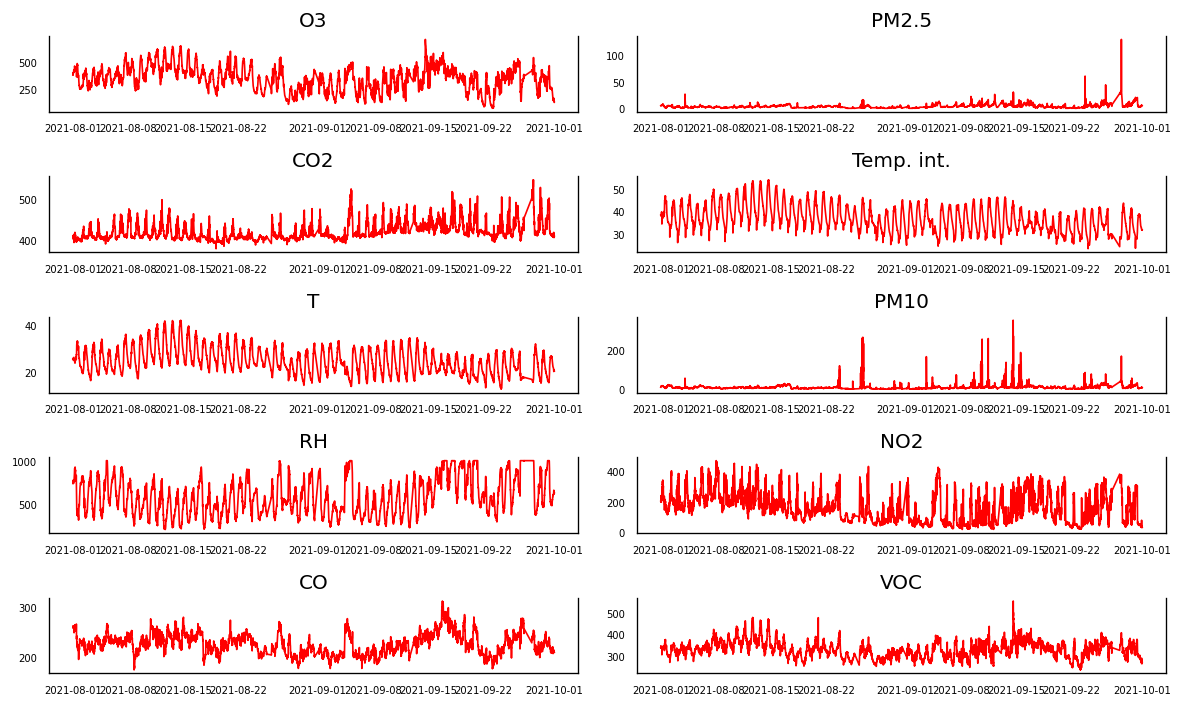

In [34]:
import pandas as pd
import psycopg2
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np
%matplotlib inline


conn = psycopg2.connect(host='playground.magentalab.it', port='45432', database='airqino', user='datareader', password='homntLZnlhQd9prtVA9SFezQek')

query=""" select time_bucket('10 minutes', c."Dates" ) as "bucket", avg(c."O3") as "O3" ,  avg(c."PM2.5") as "PM2.5", avg(c."CO2") as "CO2",
 avg(c."Temp. int.") as "Temp. int.",  avg(c."T") as "T",  avg(c."PM10") as "PM10", avg(c."RH") as "RH", avg(c."NO2") as 
 "NO2", avg(c."CO") as "CO", avg(c."VOC") as "VOC"
from (select * from crosstab(
  'select sd.data_acquired as timestamp, s.sensor_type ,  sd.float_value as value 
from station_data sd join sensor s on s.id = sd.sensor_id
where sd.data_acquired >= to_timestamp(''2021-08-01 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
 and sd.data_acquired <= to_timestamp(''2021-10-01 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
and sd.station_id = 23284701 order by sd.data_acquired asc, 1'
 , $$VALUES ('O3'::varchar), ('PM2.5'::varchar), ('CO2'::varchar), ('Temp. int.'::varchar), ('T'::varchar)
 , ('PM10'::varchar), ('RH'::varchar), ('NO2'::varchar), ('CO'::varchar), ('VOC'::varchar)$$
) AS value ("Dates" timestamp, "O3" float, "PM2.5" float, "CO2" float, "Temp. int." float, "T" float, "PM10" float,
"RH" float, "NO2" float, "CO" float, "VOC" float))  c 
group by bucket
order by bucket asc;
 """
df_f = pd.read_sql(query, conn)
df_f= df_f.rename(columns={'bucket': 'Dates'})
df_f=df_f.set_index('Dates')
#fix temp int
df_f['Temp. int.'] = df_f['Temp. int.'].div(100)
df_f['T'] = df_f['T'].div(10)

display(df_f)

# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df_f[df_f.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df_f.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Splitting the series into train and testing data

In [35]:
nobs = 144
df_train, df_test = df_f[0:-nobs], df_f[-nobs:]

# Check size
print(df_train.shape)  
print(df_test.shape)  

(8285, 10)
(144, 10)


# Testing stationarity 

In [36]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results = {
    col: test_stationarity(df_train, col)
    for col in df_train.columns
}
adf_test_results  

{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Stationary',
 'O3': 'Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Stationary',
 'RH': 'Stationary',
 'T': 'Stationary',
 'Temp. int.': 'Stationary',
 'VOC': 'Stationary'}

First differencing

In [ ]:
df_differenced = df_train.diff().dropna()


In [ ]:
adf_test_results = {
    col: test_stationarity(df_differenced, col)
    for col in df_differenced.columns
}
adf_test_results 

{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Stationary',
 'O3': 'Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Stationary',
 'RH': 'Non-Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Stationary'}

Second differencing

In [ ]:
df_differenced = df_differenced.diff().dropna()


In [ ]:
adf_test_results = {
    col: test_stationarity(df_differenced, col)
    for col in df_differenced.columns
}
adf_test_results 

{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Stationary',
 'O3': 'Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Stationary',
 'RH': 'Stationary',
 'T': 'Stationary',
 'Temp. int.': 'Stationary',
 'VOC': 'Stationary'}

if no differencing

In [37]:
df_differenced=df_train

# Forecasting VAR model

Selecting lag

In [38]:
from statsmodels.tsa.api import VAR

model = VAR(df_differenced)
order = model.select_order(maxlags=20)
lag = order.aic
print(lag)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


18


In [39]:
model_fitted = model.fit(lag)

In [40]:
# Input data for forecasting
forecast_input = df_differenced.values
forecast_input

array([[381.33333333,   5.        , 409.        , ..., 202.5       ,
        260.33333333, 338.33333333],
       [384.14285714,   5.        , 407.42857143, ..., 199.42857143,
        258.42857143, 337.14285714],
       [383.83333333,   5.        , 407.5       , ..., 209.16666667,
        259.33333333, 338.66666667],
       ...,
       [317.        ,  13.        , 430.85714286, ..., 104.42857143,
        230.42857143, 325.14285714],
       [295.        ,  13.        , 428.25      , ...,  90.5       ,
        227.25      , 317.5       ],
       [281.        ,  12.71428571, 426.71428571, ...,  92.85714286,
        227.85714286, 317.85714286]])

In [41]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_f.index[-nobs:], columns=df_f.columns + '_2d')
df_forecast

,O3_2d,PM2.5_2d,CO2_2d,Temp. int._2d,T_2d,PM10_2d,RH_2d,NO2_2d,CO_2d,VOC_2d
Dates,,,,,,,,,,
2021-09-30 00:10:00,281.654550,12.019160,428.222327,30.440613,18.707759,13.422889,892.375665,113.582060,230.335857,322.509168
2021-09-30 00:20:00,283.465094,11.750884,429.691521,30.482454,18.610970,15.047253,895.182430,116.258471,230.470484,322.796972
2021-09-30 00:30:00,285.394053,11.600321,430.598387,30.409113,18.551053,13.664542,896.299759,121.367036,231.085301,324.386882
2021-09-30 00:40:00,290.408367,12.073735,433.830232,30.383591,18.475041,16.198510,897.845887,134.458736,231.141317,325.927336
2021-09-30 00:50:00,296.289039,12.348443,435.454366,30.357355,18.371755,16.247318,900.577707,142.751324,232.184040,328.889637
...,...,...,...,...,...,...,...,...,...,...
2021-09-30 23:20:00,311.210791,4.416393,426.432397,35.034503,23.051818,10.648153,600.495872,129.054743,221.774230,322.877469
2021-09-30 23:30:00,311.170259,4.411218,426.436128,35.023406,23.041605,10.626776,600.721581,129.266008,221.801879,322.858450
2021-09-30 23:40:00,311.138498,4.406252,426.440612,35.012640,23.031656,10.606262,600.946633,129.479392,221.828872,322.841406


In [ ]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results=df_results.loc[:, ['O3_forecast', 'PM2.5_forecast', 'CO2_forecast', 'Temp. int._forecast',
                   'T_forecast', 'PM10_forecast', 'RH_forecast', 'NO2_forecast','CO2_forecast','VOC_forecast']]
display(df_results)

If no differencing

In [42]:
df_results=df_forecast

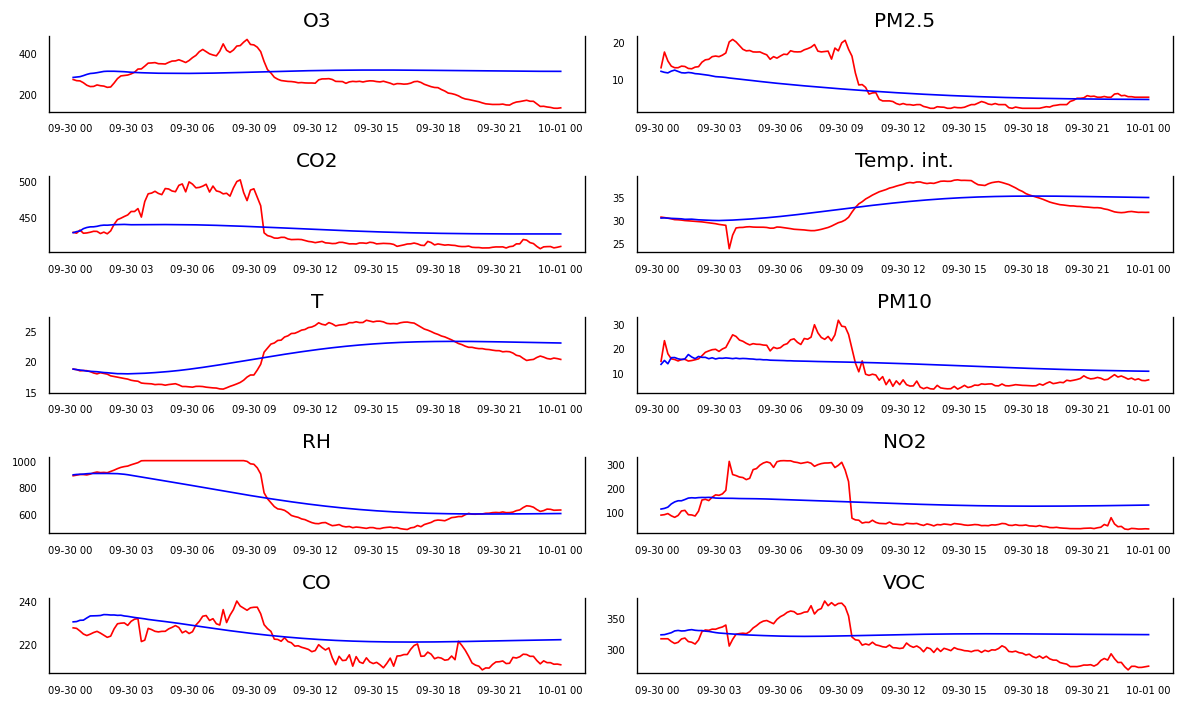

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data_3 = df_test[df_test.columns[i]]
    data_fc=df_results[df_results.columns[i]]
    ax.plot(data_3, color='red', linewidth=1)
    ax.plot(data_fc, color='blue', linewidth=1)
    # Decorations
    ax.set_title(df_f.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();